# Imports and dataset download

In [ ]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False
IMG_SIZE = 28

In [ ]:
def get_MNIST_subset_np(create_subset=False, data_per_pattern=1000):
  notebook_path = os.path.abspath("CNN_MNIST.ipynb")
  labels_path = os.path.join(os.path.dirname(notebook_path), "data/MNIST/MNIST.npy")
  data_path = os.path.join(os.path.dirname(notebook_path), "data/MNIST/MNIST_labels.npy")

  if(create_subset):
    transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])
    train = datasets.MNIST("./data/MNIST", train=True, download=True, transform=transform)
    trainset = torch.utils.data.DataLoader(train, batch_size=1, shuffle=shuffle)
    data = []
    labels = []
    dict_counter = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    data_per_pattern = data_per_pattern

    for datapoint in enumerate(trainset):
      current_size = sum(dict_counter.values())
      target_size = len(dict_counter) * data_per_pattern

      if current_size >= target_size: break
      batch_idx, (example_data, example_targets) = datapoint
      example_targets = example_targets.item()

      if example_targets in dict_counter and dict_counter[example_targets] < data_per_pattern:
        dict_counter[example_targets] += 1
        example_data = example_data.view(1, IMG_SIZE, IMG_SIZE)
        data.append(np.array(example_data))
        labels.append(example_targets)
        
        
    
    np.save(data_path, data)
    np.save(labels_path, labels)

  # Load data
  data = np.load(data_path)
  labels = np.load(labels_path)

  return data, labels

In [ ]:
def get_MNIST_subset_dataloader(batch_size=50, create_subset=False, data_per_pattern=1000):
	data, labels = get_MNIST_subset_np(create_subset, data_per_pattern)
	# data = data.astype(float) / 255 # normalise
	data_reshaped = data.reshape(len(data),-1) # reshape for k-means
	print(data.shape)
	print(data_reshaped.shape)

	# Convert to tensor dataset
	data = torch.Tensor(data)
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)
	return data, data_reshaped, labels, dataloader

In [ ]:
images, images_reshaped, labels, dataloader = get_MNIST_subset_dataloader(200, True, 1000)

(10000, 1, 28, 28)
(10000, 784)


# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
  
    def __init__(self, input_dimension, hl1_neurons = 32, hl2_neurons = 64, hl3_neurons = 128, latent_dimension = 10):
        super().__init__()

        # Encoder Model
        # self.input_dimension = input_dimension
        # self.hl1_neurons = hl1_neurons
        # self.hl2_neurons = hl2_neurons
        # self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Conv2d(1, hl1_neurons, kernel_size = 5, stride = 2, padding = 2),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(hl1_neurons),

          nn.Conv2d(hl1_neurons, hl2_neurons, kernel_size = 5, stride = 2, padding = 2),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(hl2_neurons),

          nn.Conv2d(hl2_neurons, hl3_neurons, kernel_size = 3, stride = 2, padding = 0),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(hl3_neurons),

          nn.Flatten(start_dim=1),
          nn.Linear(hl3_neurons * 3 * 3, latent_dimension, bias=True), # latent_dimension * 3 * 3
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(latent_dimension)
        )
        
        # Latent Space
        # self.latent_space = nn.Sequential(
        #   nn.Linear(self.hl2_neurons, self.latent_dimension),
        #   nn.Sigmoid(),
        #   nn.BatchNorm1d(self.latent_dimension),
        # )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(latent_dimension,  hl3_neurons * 3 * 3, bias=True),
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(hl3_neurons * 3 * 3),
          nn.Unflatten(dim = 1, unflattened_size =  (hl3_neurons, 3, 3)),

          nn.ConvTranspose2d(hl3_neurons, hl2_neurons, kernel_size = 3, stride = 2, padding = 0),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(hl2_neurons),
          
          nn.ConvTranspose2d(hl2_neurons, hl1_neurons, kernel_size = 5, stride = 2, padding = 2, output_padding = 1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(hl1_neurons),
          
          nn.ConvTranspose2d(hl1_neurons, 1, kernel_size = 5, stride = 2, padding = 2, output_padding = 1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(1)
        )
  
    def forward(self, x):
      x = self.encoder_model(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = self.encoder_model(x.to(device=device))
      return x

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, epochs):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 200
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Clustering

In [ ]:
kmeans_10_clusters = KMeans(n_clusters=10, n_init=10).fit(images_reshaped)
retrieved_labels_10_clusters = transform_clusters_to_labels(kmeans_10_clusters.labels_, labels)

print("K_means greedy accuracy score for 8 clusters on initial space:",accuracy_score(labels, retrieved_labels_10_clusters))
# print("K_means hungarian accuracy score for 8 clusters on initial space:",cluster_accuracy(labels, kmeans_10_clusters.labels_)[1])
print("K-means normalised mutual info score for 8 clusters on initial space:",normalized_mutual_info_score(labels, kmeans_10_clusters.labels_))
print("K-means ARI for 8 clusters on initial space:",adjusted_rand_score(labels, kmeans_10_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(images_reshaped, kmeans_10_clusters.labels_))

K_means greedy accuracy score for 8 clusters on initial space: 0.5581
K-means normalised mutual info score for 8 clusters on initial space: 0.4927704835704977
K-means ARI for 8 clusters on initial space: 0.3578612674690206
K-means silhouette score for 2 clusters on initial space: 0.07476837


In [ ]:
aggloClustering_10_clusters = AgglomerativeClustering(n_clusters=10).fit(images_reshaped)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_10_clusters.labels_, labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(labels, agglo_retrieved_labels))
# print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(labels, aggloClustering_10_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(labels, aggloClustering_10_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(labels, aggloClustering_10_clusters.labels_))
print("Agglomerative clustering silhouette score for 2 clusters on initial space:",silhouette_score(images_reshaped, aggloClustering_10_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.6553
Normalised mutual info score on agglomerative clustering on initial space: 0.6629064246339391
Agglomerative clustering ARI on initial space: 0.4938958717431919
Agglomerative clustering silhouette score for 2 clusters on initial space: 0.040455837


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(images_reshaped)

dataset_labels = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, datapoints_reshaped, labels, epochs=30, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=10).fit(datapoints_reshaped) 
  # cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  # kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  # print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  agglo_silhouette_scores = []
  
  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, hl3_neurons=hl3_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs)
    latent_data = autoencoder.encoder(datapoints, device).cpu().detach().numpy() 

    # data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    # dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    # plt.figure(figsize=(16,10))
    # scatterplot = plt.scatter(
    #     x=data_TSNE[:,0], y=data_TSNE[:,1],
    #     c=labels,
    #     cmap="tab10"
    # )

    # handles, _ = scatterplot.legend_elements(prop='colors')
    # plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=10, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    # kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_greedy_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    # print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=10).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    # agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    agglo_silhouette_score = silhouette_score(latent_data, aggloClustering_clusters)
    agglo_silhouette_scores.append(agglo_silhouette_score)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    # print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores, agglo_silhouette_scores]

In [ ]:
results_for_k_20 = run_experiment(20, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.7104
Normalised mutual info score (initial space): 0.6094772166486544
ARI (initial space): 0.5261557817034651 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.937462
Epoch: 2/100, Loss: 0.732700
Epoch: 3/100, Loss: 0.650502
Epoch: 4/100, Loss: 0.610216
Epoch: 5/100, Loss: 0.586235
Epoch: 6/100, Loss: 0.568578
Epoch: 7/100, Loss: 0.554025
Epoch: 8/100, Loss: 0.541302
Epoch: 9/100, Loss: 0.529806
Epoch: 10/100, Loss: 0.519195
Epoch: 11/100, Loss: 0.509235
Epoch: 12/100, Loss: 0.499784
Epoch: 13/100, Loss: 0.490734
Epoch: 14/100, Loss: 0.482018
Epoch: 15/100, Loss: 0.473590
Epoch: 16/100, Loss: 0.465421
Epoch: 17/100, Loss: 0.457479
Epoch: 18/100, Loss: 0.449743
Epoch: 19/100, Loss: 0.442192
Epoch: 20/100, Loss: 0.434822
Epoch: 21/100, Loss: 0.427624
Epoch: 22/100, Loss: 0.420577
Epoch: 23/

In [ ]:
results_for_k_30 = run_experiment(30, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.7421
Normalised mutual info score (initial space): 0.6449980640633176
ARI (initial space): 0.5652713133960403 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.932937
Epoch: 2/100, Loss: 0.728996
Epoch: 3/100, Loss: 0.648768
Epoch: 4/100, Loss: 0.611429
Epoch: 5/100, Loss: 0.588258
Epoch: 6/100, Loss: 0.570784
Epoch: 7/100, Loss: 0.556252
Epoch: 8/100, Loss: 0.543443
Epoch: 9/100, Loss: 0.531787
Epoch: 10/100, Loss: 0.520973
Epoch: 11/100, Loss: 0.510806
Epoch: 12/100, Loss: 0.501148
Epoch: 13/100, Loss: 0.491913
Epoch: 14/100, Loss: 0.483033
Epoch: 15/100, Loss: 0.474465
Epoch: 16/100, Loss: 0.466167
Epoch: 17/100, Loss: 0.458105
Epoch: 18/100, Loss: 0.450264
Epoch: 19/100, Loss: 0.442617
Epoch: 20/100, Loss: 0.435153
Epoch: 21/100, Loss: 0.427866
Epoch: 22/100, Loss: 0.420744
Epoch: 23/

In [ ]:
results_for_k_40 = run_experiment(40, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.7844
Normalised mutual info score (initial space): 0.6759921486097289
ARI (initial space): 0.6199536553629289 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.933880
Epoch: 2/100, Loss: 0.761963
Epoch: 3/100, Loss: 0.672428
Epoch: 4/100, Loss: 0.621254
Epoch: 5/100, Loss: 0.591482
Epoch: 6/100, Loss: 0.571616
Epoch: 7/100, Loss: 0.556237
Epoch: 8/100, Loss: 0.543176
Epoch: 9/100, Loss: 0.531543
Epoch: 10/100, Loss: 0.520840
Epoch: 11/100, Loss: 0.510788
Epoch: 12/100, Loss: 0.501241
Epoch: 13/100, Loss: 0.492117
Epoch: 14/100, Loss: 0.483344
Epoch: 15/100, Loss: 0.474881
Epoch: 16/100, Loss: 0.466684
Epoch: 17/100, Loss: 0.458723
Epoch: 18/100, Loss: 0.450972
Epoch: 19/100, Loss: 0.443415
Epoch: 20/100, Loss: 0.436040
Epoch: 21/100, Loss: 0.428831
Epoch: 22/100, Loss: 0.421782
Epoch: 23/

In [ ]:
results_for_k_50 = run_experiment(50, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8101
Normalised mutual info score (initial space): 0.6983006792050575
ARI (initial space): 0.6500735528737586 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.901812
Epoch: 2/100, Loss: 0.716151
Epoch: 3/100, Loss: 0.644579
Epoch: 4/100, Loss: 0.608878
Epoch: 5/100, Loss: 0.585409
Epoch: 6/100, Loss: 0.567781
Epoch: 7/100, Loss: 0.553325
Epoch: 8/100, Loss: 0.540695
Epoch: 9/100, Loss: 0.529218
Epoch: 10/100, Loss: 0.518557
Epoch: 11/100, Loss: 0.508500
Epoch: 12/100, Loss: 0.498934
Epoch: 13/100, Loss: 0.489768
Epoch: 14/100, Loss: 0.480947
Epoch: 15/100, Loss: 0.472431
Epoch: 16/100, Loss: 0.464179
Epoch: 17/100, Loss: 0.456173
Epoch: 18/100, Loss: 0.448385
Epoch: 19/100, Loss: 0.440797
Epoch: 20/100, Loss: 0.433393
Epoch: 21/100, Loss: 0.426155
Epoch: 22/100, Loss: 0.419079
Epoch: 23/

In [ ]:
results_for_k_60 = run_experiment(60, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8073
Normalised mutual info score (initial space): 0.6974304113284331
ARI (initial space): 0.6467915497396858 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.912483
Epoch: 2/100, Loss: 0.724748
Epoch: 3/100, Loss: 0.650582
Epoch: 4/100, Loss: 0.612820
Epoch: 5/100, Loss: 0.588240
Epoch: 6/100, Loss: 0.569890
Epoch: 7/100, Loss: 0.554844
Epoch: 8/100, Loss: 0.541785
Epoch: 9/100, Loss: 0.530055
Epoch: 10/100, Loss: 0.519258
Epoch: 11/100, Loss: 0.509152
Epoch: 12/100, Loss: 0.499569
Epoch: 13/100, Loss: 0.490407
Epoch: 14/100, Loss: 0.481601
Epoch: 15/100, Loss: 0.473114
Epoch: 16/100, Loss: 0.464890
Epoch: 17/100, Loss: 0.456904
Epoch: 18/100, Loss: 0.449136
Epoch: 19/100, Loss: 0.441567
Epoch: 20/100, Loss: 0.434176
Epoch: 21/100, Loss: 0.426946
Epoch: 22/100, Loss: 0.419871
Epoch: 23/

In [ ]:
results_for_k_70 = run_experiment(70, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 70 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8354
Normalised mutual info score (initial space): 0.7232658655637275
ARI (initial space): 0.6894906370911381 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.957514
Epoch: 2/100, Loss: 0.747950
Epoch: 3/100, Loss: 0.661419
Epoch: 4/100, Loss: 0.617895
Epoch: 5/100, Loss: 0.591756
Epoch: 6/100, Loss: 0.573061
Epoch: 7/100, Loss: 0.557853
Epoch: 8/100, Loss: 0.544593
Epoch: 9/100, Loss: 0.532611
Epoch: 10/100, Loss: 0.521542
Epoch: 11/100, Loss: 0.511191
Epoch: 12/100, Loss: 0.501411
Epoch: 13/100, Loss: 0.492092
Epoch: 14/100, Loss: 0.483168
Epoch: 15/100, Loss: 0.474573
Epoch: 16/100, Loss: 0.466263
Epoch: 17/100, Loss: 0.458199
Epoch: 18/100, Loss: 0.450361
Epoch: 19/100, Loss: 0.442728
Epoch: 20/100, Loss: 0.435281
Epoch: 21/100, Loss: 0.428001
Epoch: 22/100, Loss: 0.420881
Epoch: 23/

In [ ]:
results_for_k_80 = run_experiment(80, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 80 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8435
Normalised mutual info score (initial space): 0.73265413982975
ARI (initial space): 0.7006664614870293 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.943787
Epoch: 2/100, Loss: 0.743224
Epoch: 3/100, Loss: 0.661344
Epoch: 4/100, Loss: 0.620281
Epoch: 5/100, Loss: 0.593980
Epoch: 6/100, Loss: 0.574368
Epoch: 7/100, Loss: 0.558605
Epoch: 8/100, Loss: 0.545226
Epoch: 9/100, Loss: 0.533332
Epoch: 10/100, Loss: 0.522437
Epoch: 11/100, Loss: 0.512255
Epoch: 12/100, Loss: 0.502609
Epoch: 13/100, Loss: 0.493387
Epoch: 14/100, Loss: 0.484529
Epoch: 15/100, Loss: 0.475978
Epoch: 16/100, Loss: 0.467694
Epoch: 17/100, Loss: 0.459651
Epoch: 18/100, Loss: 0.451827
Epoch: 19/100, Loss: 0.444205
Epoch: 20/100, Loss: 0.436762
Epoch: 21/100, Loss: 0.429490
Epoch: 22/100, Loss: 0.422370
Epoch: 23/10

In [ ]:
results_for_k_100 = run_experiment(100, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 100 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8529
Normalised mutual info score (initial space): 0.7435490582432477
ARI (initial space): 0.7149857876358806 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.938258
Epoch: 2/100, Loss: 0.731635
Epoch: 3/100, Loss: 0.658476
Epoch: 4/100, Loss: 0.621519
Epoch: 5/100, Loss: 0.598092
Epoch: 6/100, Loss: 0.580176
Epoch: 7/100, Loss: 0.564732
Epoch: 8/100, Loss: 0.550781
Epoch: 9/100, Loss: 0.538032
Epoch: 10/100, Loss: 0.526317
Epoch: 11/100, Loss: 0.515404
Epoch: 12/100, Loss: 0.505118
Epoch: 13/100, Loss: 0.495343
Epoch: 14/100, Loss: 0.486013
Epoch: 15/100, Loss: 0.477039
Epoch: 16/100, Loss: 0.468405
Epoch: 17/100, Loss: 0.460060
Epoch: 18/100, Loss: 0.451978
Epoch: 19/100, Loss: 0.444131
Epoch: 20/100, Loss: 0.436505
Epoch: 21/100, Loss: 0.429076
Epoch: 22/100, Loss: 0.421822
Epoch: 23

In [ ]:
results_for_k_150 = run_experiment(150, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 150 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8738
Normalised mutual info score (initial space): 0.7705088909624284
ARI (initial space): 0.7506550534402108 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.924478
Epoch: 2/100, Loss: 0.730658
Epoch: 3/100, Loss: 0.655697
Epoch: 4/100, Loss: 0.618224
Epoch: 5/100, Loss: 0.593085
Epoch: 6/100, Loss: 0.573992
Epoch: 7/100, Loss: 0.558596
Epoch: 8/100, Loss: 0.545362
Epoch: 9/100, Loss: 0.533477
Epoch: 10/100, Loss: 0.522493
Epoch: 11/100, Loss: 0.512200
Epoch: 12/100, Loss: 0.502451
Epoch: 13/100, Loss: 0.493148
Epoch: 14/100, Loss: 0.484221
Epoch: 15/100, Loss: 0.475622
Epoch: 16/100, Loss: 0.467298
Epoch: 17/100, Loss: 0.459218
Epoch: 18/100, Loss: 0.451361
Epoch: 19/100, Loss: 0.443704
Epoch: 20/100, Loss: 0.436237
Epoch: 21/100, Loss: 0.428936
Epoch: 22/100, Loss: 0.421794
Epoch: 23

In [ ]:
results_for_k_200 = run_experiment(200, dataloader, 784, datapoints = images, datapoints_reshaped = images_reshaped, labels = labels, epochs=100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10)

Experiment results for k-means with k = 200 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8925
Normalised mutual info score (initial space): 0.7909753888653926
ARI (initial space): 0.7817729314941033 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/100, Loss: 0.900119
Epoch: 2/100, Loss: 0.712290
Epoch: 3/100, Loss: 0.642178
Epoch: 4/100, Loss: 0.607354
Epoch: 5/100, Loss: 0.584438
Epoch: 6/100, Loss: 0.566980
Epoch: 7/100, Loss: 0.552507
Epoch: 8/100, Loss: 0.539860
Epoch: 9/100, Loss: 0.528406
Epoch: 10/100, Loss: 0.517789
Epoch: 11/100, Loss: 0.507798
Epoch: 12/100, Loss: 0.498305
Epoch: 13/100, Loss: 0.489212
Epoch: 14/100, Loss: 0.480461
Epoch: 15/100, Loss: 0.472014
Epoch: 16/100, Loss: 0.463830
Epoch: 17/100, Loss: 0.455879
Epoch: 18/100, Loss: 0.448141
Epoch: 19/100, Loss: 0.440594
Epoch: 20/100, Loss: 0.433232
Epoch: 21/100, Loss: 0.426033
Epoch: 22/100, Loss: 0.418991
Epoch: 23

In [ ]:
kmeans_acc = np.zeros((10,10))
kmeans_NMI = np.zeros((10,10))
kmeans_ARI = np.zeros((10,10))
agglo_acc = np.zeros((10,10))
agglo_NMI = np.zeros((10,10))
agglo_ARI = np.zeros((10,10))
kmeans_silhouette = np.zeros((10,10))
agglo_silhouette = np.zeros((10,10))

for i in range(10):
  
  kmeans_acc[i][0] = results_for_k_20[0][i]
  kmeans_acc[i][1] = results_for_k_30[0][i]
  kmeans_acc[i][2] = results_for_k_40[0][i]
  kmeans_acc[i][3] = results_for_k_50[0][i]
  kmeans_acc[i][4] = results_for_k_60[0][i]
  kmeans_acc[i][5] = results_for_k_70[0][i]
  kmeans_acc[i][6] = results_for_k_80[0][i]
  kmeans_acc[i][7] = results_for_k_100[0][i]
  kmeans_acc[i][8] = results_for_k_150[0][i]
  kmeans_acc[i][9] = results_for_k_200[0][i]

  kmeans_NMI[i][0] = results_for_k_20[1][i]
  kmeans_NMI[i][1] = results_for_k_30[1][i]
  kmeans_NMI[i][2] = results_for_k_40[1][i]
  kmeans_NMI[i][3] = results_for_k_50[1][i]
  kmeans_NMI[i][4] = results_for_k_60[1][i]
  kmeans_NMI[i][5] = results_for_k_70[1][i]
  kmeans_NMI[i][6] = results_for_k_80[1][i]
  kmeans_NMI[i][7] = results_for_k_100[1][i]
  kmeans_NMI[i][8] = results_for_k_150[1][i]
  kmeans_NMI[i][9] = results_for_k_200[1][i]

  kmeans_ARI[i][0] = results_for_k_20[2][i]
  kmeans_ARI[i][1] = results_for_k_30[2][i]
  kmeans_ARI[i][2] = results_for_k_40[2][i]
  kmeans_ARI[i][3] = results_for_k_50[2][i]
  kmeans_ARI[i][4] = results_for_k_60[2][i]
  kmeans_ARI[i][5] = results_for_k_70[2][i]
  kmeans_ARI[i][6] = results_for_k_80[2][i]
  kmeans_ARI[i][7] = results_for_k_100[2][i]
  kmeans_ARI[i][8] = results_for_k_150[2][i]
  kmeans_ARI[i][9] = results_for_k_200[2][i]

  agglo_acc[i][0] = results_for_k_20[3][i]
  agglo_acc[i][1] = results_for_k_30[3][i]
  agglo_acc[i][2] = results_for_k_40[3][i]
  agglo_acc[i][3] = results_for_k_50[3][i]
  agglo_acc[i][4] = results_for_k_60[3][i]
  agglo_acc[i][5] = results_for_k_70[3][i]
  agglo_acc[i][6] = results_for_k_80[3][i]
  agglo_acc[i][7] = results_for_k_100[3][i]
  agglo_acc[i][8] = results_for_k_150[3][i]
  agglo_acc[i][9] = results_for_k_200[3][i]

  agglo_NMI[i][0] = results_for_k_20[4][i]
  agglo_NMI[i][1] = results_for_k_30[4][i]
  agglo_NMI[i][2] = results_for_k_40[4][i]
  agglo_NMI[i][3] = results_for_k_50[4][i]
  agglo_NMI[i][4] = results_for_k_60[4][i]
  agglo_NMI[i][5] = results_for_k_70[4][i]
  agglo_NMI[i][6] = results_for_k_80[4][i]
  agglo_NMI[i][7] = results_for_k_100[4][i]
  agglo_NMI[i][8] = results_for_k_150[4][i]
  agglo_NMI[i][9] = results_for_k_200[4][i]

  agglo_ARI[i][0] = results_for_k_20[5][i]
  agglo_ARI[i][1] = results_for_k_30[5][i]
  agglo_ARI[i][2] = results_for_k_40[5][i]
  agglo_ARI[i][3] = results_for_k_50[5][i]
  agglo_ARI[i][4] = results_for_k_60[5][i]
  agglo_ARI[i][5] = results_for_k_70[5][i]
  agglo_ARI[i][6] = results_for_k_80[5][i]
  agglo_ARI[i][7] = results_for_k_100[5][i]
  agglo_ARI[i][8] = results_for_k_150[5][i]
  agglo_ARI[i][9] = results_for_k_200[5][i]

  kmeans_silhouette[i][0] = results_for_k_20[6][i]
  kmeans_silhouette[i][1] = results_for_k_30[6][i]
  kmeans_silhouette[i][2] = results_for_k_40[6][i]
  kmeans_silhouette[i][3] = results_for_k_50[6][i]
  kmeans_silhouette[i][4] = results_for_k_60[6][i]
  kmeans_silhouette[i][5] = results_for_k_70[6][i]
  kmeans_silhouette[i][6] = results_for_k_80[6][i]
  kmeans_silhouette[i][7] = results_for_k_100[6][i]
  kmeans_silhouette[i][8] = results_for_k_150[6][i]
  kmeans_silhouette[i][9] = results_for_k_200[6][i]

  agglo_silhouette[i][0] = results_for_k_20[7][i]
  agglo_silhouette[i][1] = results_for_k_30[7][i]
  agglo_silhouette[i][2] = results_for_k_40[7][i]
  agglo_silhouette[i][3] = results_for_k_50[7][i]
  agglo_silhouette[i][4] = results_for_k_60[7][i]
  agglo_silhouette[i][5] = results_for_k_70[7][i]
  agglo_silhouette[i][6] = results_for_k_80[7][i]
  agglo_silhouette[i][7] = results_for_k_100[7][i]
  agglo_silhouette[i][8] = results_for_k_150[7][i]
  agglo_silhouette[i][9] = results_for_k_200[7][i]



Text(0.5, 0, 'K')

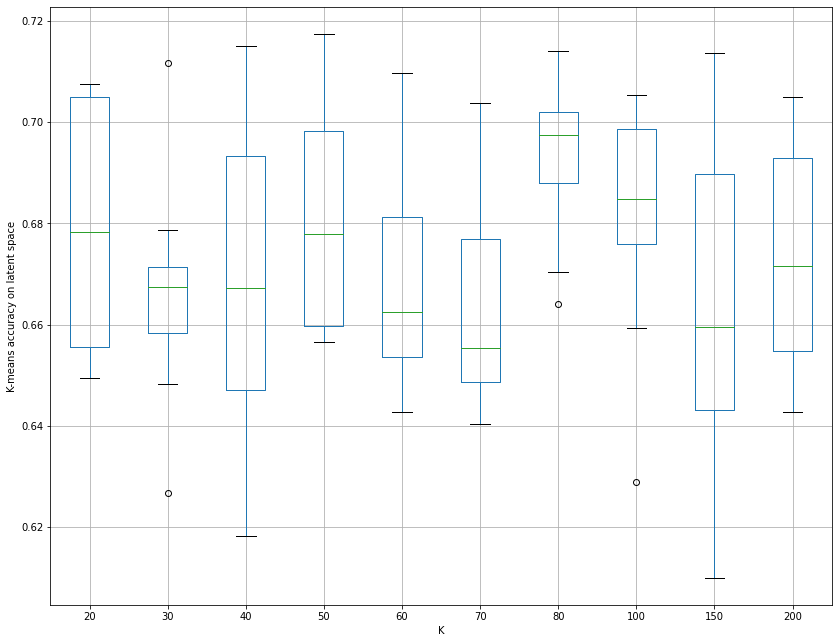

In [ ]:
columns = ['20', '30', '40', '50', '60', '70', '80', '100', '150', '200']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

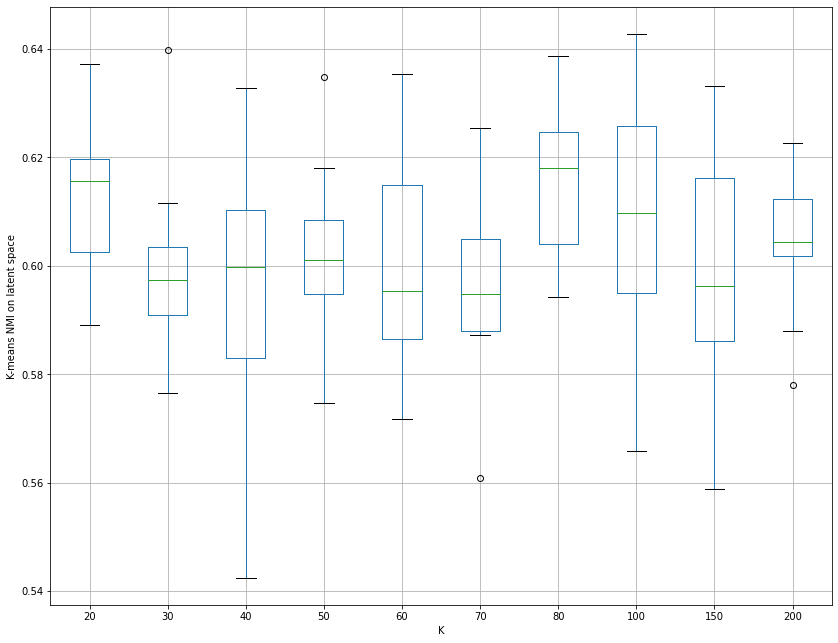

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

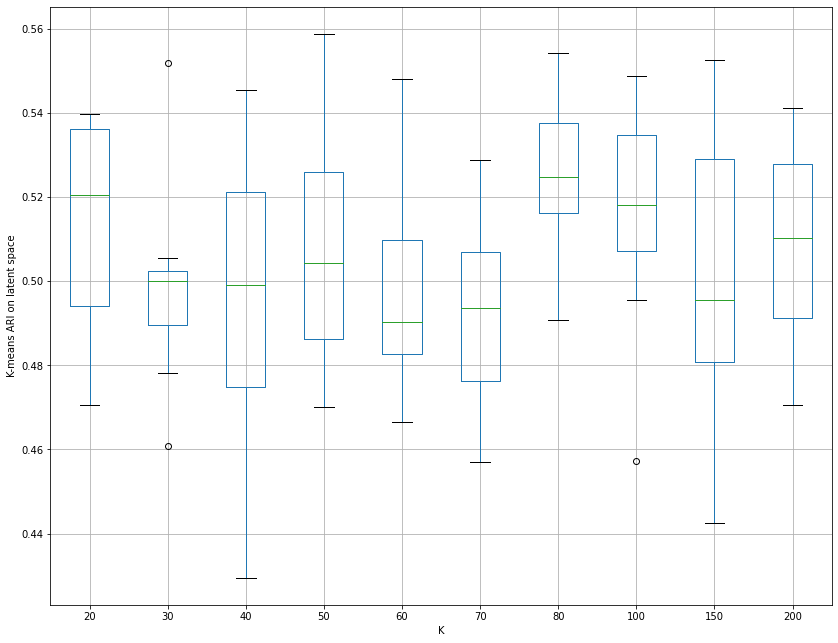

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

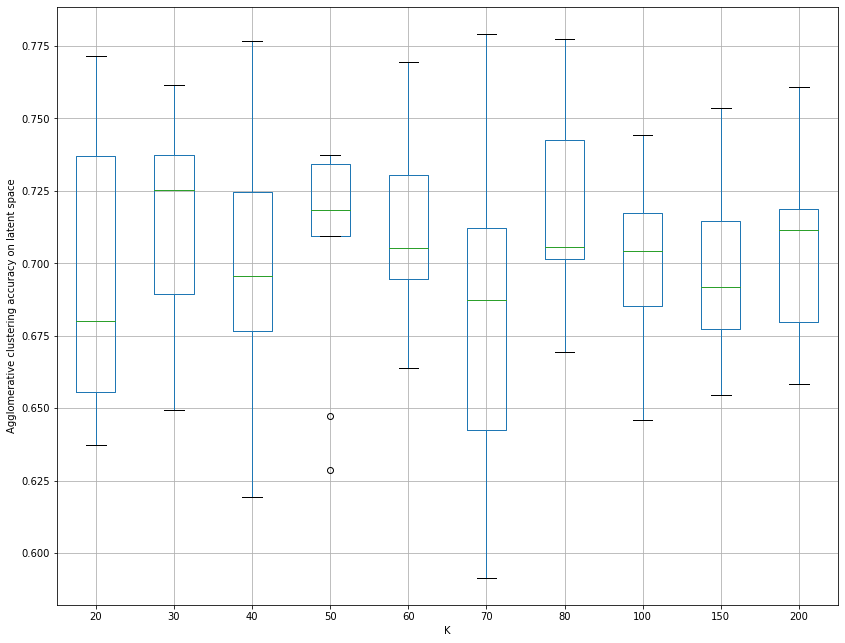

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

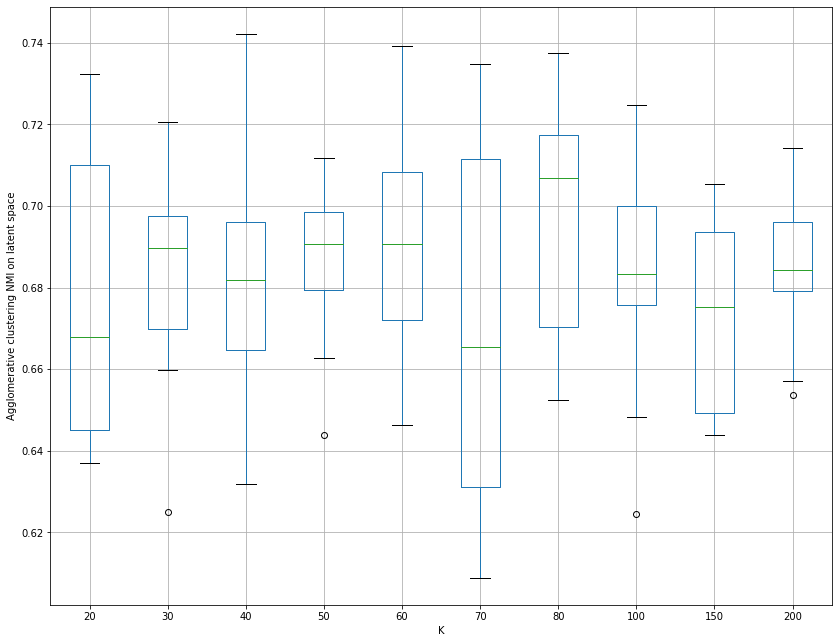

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

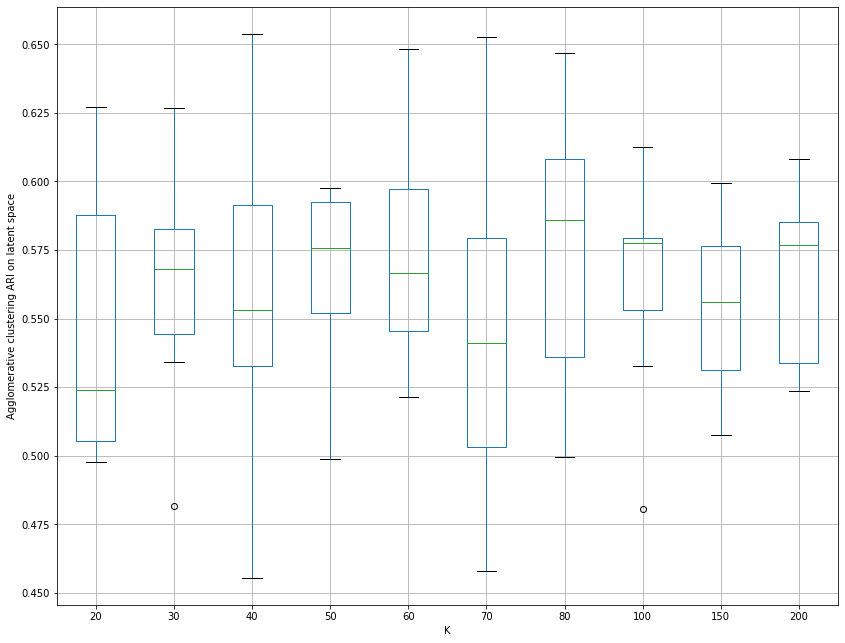

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

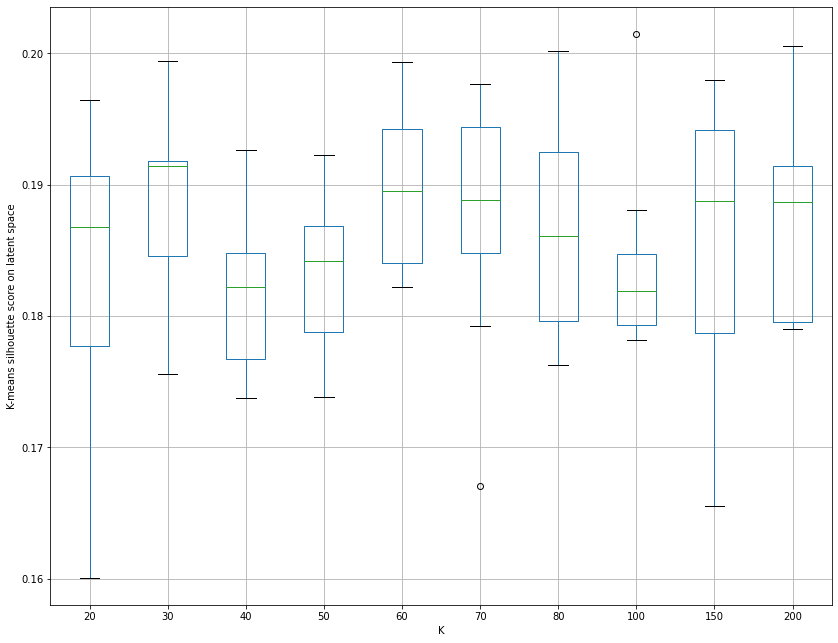

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

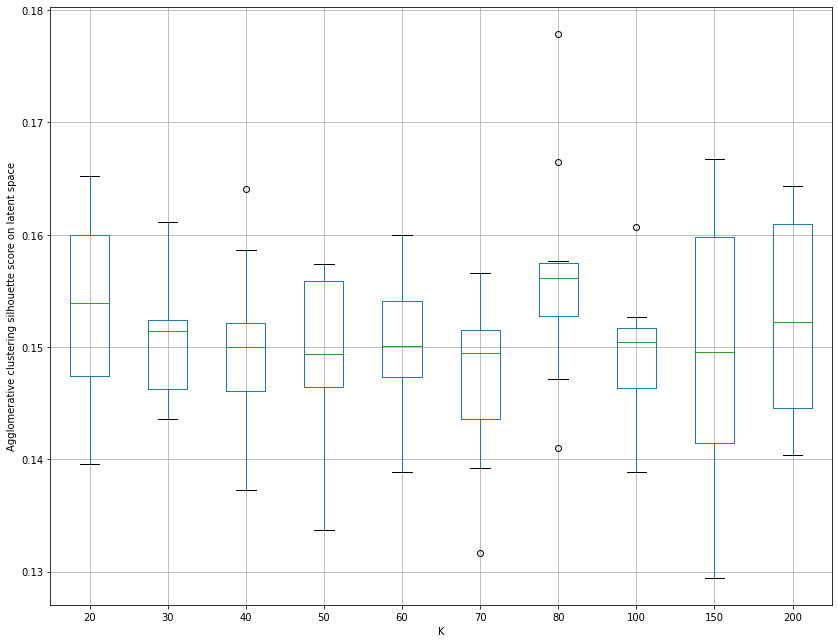

In [ ]:
df = pd.DataFrame(agglo_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering silhouette score on latent space')
boxplot.set_xlabel('K')

# Silhoutte factor

In [ ]:
def get_all_representations(dataloader, data_shape, datapoints, datapoints_reshaped, labels, epochs, hl1_neurons, hl2_neurons, hl3_neurons, latent_dimension, list_of_cluster_numbers):

  representation_K_tuples = []

  for K in list_of_cluster_numbers:
    print("Creating representation for K =", K, ":\n")
    print("Running k-means...\n")
    kmeans = KMeans(n_clusters=K, n_init=1).fit(datapoints_reshaped)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # using the autoencoder model on our data

    print("Training autoencoder...\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, hl3_neurons=hl3_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=100)
    latent_data = autoencoder.encoder(datapoints, device).cpu().detach().numpy() 

    print("\n")
    r = latent_data

    representation_K_tuples.append((r,K))

  return representation_K_tuples


In [ ]:
def calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers):
  representations = [pair[0] for pair in representation_tuples]
  rep_silhouette_list = [[] for i in range(len(representations))]

  for index, rep in enumerate(representations):
    print("Starting process for representation number", index + 1,":\n")
    for K in list_of_cluster_numbers:
      print("Running kmeans for K =", K,"...")
      kmeans = KMeans(n_clusters=K, n_init=10).fit(rep)
      k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
      rep_silhouette_list[index].append(k_means_silhouette_score)
    print("\n")

  return rep_silhouette_list

In [ ]:
def get_max_silhouette_for_each_representation(rep_silhouette_lst):
  max_silhouette_tuples = [] # keep tuples in the form of (index, max_silhouette)

  for index, silhouette_lst in enumerate(rep_silhouette_lst):
    max = silhouette_lst[0]

    for i in range(1,len(silhouette_lst)):
        if silhouette_lst[i] > max:
            max = silhouette_lst[i]

    max_silhouette_tuples.append((index, max))

  return max_silhouette_tuples

In [ ]:
def calculate_representation_kmeans_acc(representation_tuples, Y):
  representations = [pair[0] for pair in representation_tuples]
  accuracies = []

  for index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=10, n_init=1).fit(rep)
    kmeans_clusters = kmeans.labels_
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, Y)
    acc = accuracy_score(Y, kmeans_greedy_labels)
    accuracies.append((index,acc))

  return accuracies

In [ ]:
def calculate_normalised_silhouette(max_silhouette_tuples, representation_tuples):
  normalised_silhouette_tuples = []
  representations = [pair[0] for pair in representation_tuples]

  for rep_index, rep in enumerate(representations):
    kmeans = KMeans(n_clusters=10, n_init=1).fit(rep)
    k_means_silhouette_score = silhouette_score(rep, kmeans.labels_)
    normalised_silhouette = (k_means_silhouette_score) / (max_silhouette_tuples[rep_index][1])
    normalised_silhouette_tuples.append((rep_index, normalised_silhouette))


  return normalised_silhouette_tuples

In [ ]:
def silhouette_factor(dataloader, data_shape, datapoints, datapoints_reshaped, labels, epochs, hl1_neurons, hl2_neurons, hl3_neurons, latent_dimension, list_of_cluster_numbers):
  representation_tuples = get_all_representations(dataloader, data_shape, datapoints, datapoints_reshaped, labels, epochs, hl1_neurons, hl2_neurons, hl3_neurons, latent_dimension, list_of_cluster_numbers)
  representation_silhouette_list = calculate_silhouette_for_each_representation(representation_tuples, list_of_cluster_numbers)
  max_silhouette_list = get_max_silhouette_for_each_representation(representation_silhouette_list)
  normalised_silhouette_scores = calculate_normalised_silhouette(max_silhouette_list,representation_tuples)
  k_means_accuracies = calculate_representation_kmeans_acc(representation_tuples, labels)
  print(normalised_silhouette_scores)
  print(k_means_accuracies)

  return normalised_silhouette_scores, k_means_accuracies

In [ ]:
normalised_silhouette_scores, k_means_accuracies = silhouette_factor(dataloader, 784, images, images_reshaped, labels, 100, hl1_neurons=32, hl2_neurons=64, hl3_neurons=128, latent_dimension=10, list_of_cluster_numbers=[20, 30, 40, 50, 60, 70, 80, 100, 150, 200])

Creating representation for K = 20 :

Running k-means...

Training autoencoder...

Epoch: 1/100, Loss: 0.959420
Epoch: 2/100, Loss: 0.751017
Epoch: 3/100, Loss: 0.662943
Epoch: 4/100, Loss: 0.618362
Epoch: 5/100, Loss: 0.591466
Epoch: 6/100, Loss: 0.572253
Epoch: 7/100, Loss: 0.556912
Epoch: 8/100, Loss: 0.543715
Epoch: 9/100, Loss: 0.531871
Epoch: 10/100, Loss: 0.520964
Epoch: 11/100, Loss: 0.510741
Epoch: 12/100, Loss: 0.501054
Epoch: 13/100, Loss: 0.491816
Epoch: 14/100, Loss: 0.482942
Epoch: 15/100, Loss: 0.474396
Epoch: 16/100, Loss: 0.466131
Epoch: 17/100, Loss: 0.458120
Epoch: 18/100, Loss: 0.450335
Epoch: 19/100, Loss: 0.442753
Epoch: 20/100, Loss: 0.435360
Epoch: 21/100, Loss: 0.428134
Epoch: 22/100, Loss: 0.421070
Epoch: 23/100, Loss: 0.414150
Epoch: 24/100, Loss: 0.407371
Epoch: 25/100, Loss: 0.400721
Epoch: 26/100, Loss: 0.394190
Epoch: 27/100, Loss: 0.387775
Epoch: 28/100, Loss: 0.381471
Epoch: 29/100, Loss: 0.375272
Epoch: 30/100, Loss: 0.369176
Epoch: 31/100, Loss: 0.363

KeyboardInterrupt: ignored

In [ ]:
print(k_means_accuracies)

In [ ]:
list_of_cluster_numbers=[20, 30, 40, 50, 60, 70, 80, 100, 150, 200]

normalised_silhouette_scores = [t[1] for t in normalised_silhouette_scores]
k_means_accuracies = [t[1] for t in k_means_accuracies]

plt.figure(figsize=(12, 8))
plt.plot(list_of_cluster_numbers, normalised_silhouette_scores, c='b', marker='x', label='Silhouette criterion')
plt.plot(list_of_cluster_numbers, k_means_accuracies, c='r', marker='s', label='K-means accuracy')
plt.legend(loc='upper left')
plt.show()